In [5]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize 
import pandas as pd
import numpy as np
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Import data

In [6]:
main_df = pd.read_csv('apple_goog.csv', index_col=0)

In [7]:
main_df = main_df.drop_duplicates(subset='c_tweet', keep="first")

# remove rogue nan value in the tweets
main_df.drop(main_df.index[40395], inplace=True)

In [8]:
main_df.shape

(459852, 8)

# Tagging sentiment of each tweet

In [9]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):

    score = analyzer.polarity_scores(sentence)
    

    if score['compound'] >= .05:
        sent = 'positive'
    
    elif score['compound'] <= -.05:
        sent = 'negative'
       
    else:
        sent = 'neutral'
        

    return sent

In [10]:
main_df['sentiment'] = main_df.c_tweet.apply(sentiment_analyzer_scores)

In [11]:
main_df.head(5)

,date,name,username,retweets_count,search_term,likes_count,language,c_tweet,sentiment
1,2020-11-28,HyperNavJack27,jack_mangano,0,apple silicon,10,en,borderlands in on apple silicon yes yes it pla...,positive
4,2020-11-28,Erik Engheim,erikengheim,0,apple silicon,1,en,mac mini vs mac pro interesting review of pros...,positive
5,2020-11-28,Armando Monroy,ratzo,0,apple silicon,2,en,and can only imagine what the apple silicon fo...,positive
7,2020-11-28,Matthew S. Smith,matt_on_tech,1,apple silicon,4,en,to repeat something said at the debut if apple...,neutral
10,2020-11-28,Danel Omen ➐ he/him.®️,heck_wtf,0,apple silicon,0,en,is not the problem pixel size is the problem a...,negative


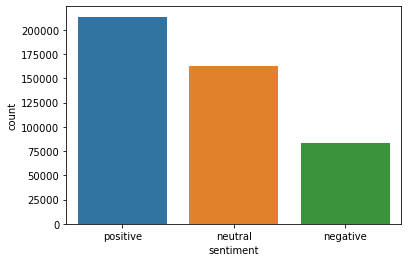

In [12]:
sns.countplot('sentiment', data=main_df);

# Seperate Dataframes by company

In [27]:
app_sil_df = main_df[main_df.search_term=="apple silicon"]
google_pixel_5_df = main_df[main_df.search_term=="google pixel 5"]
m1_macbook_df = main_df[main_df.search_term=="M1 macbook"]
new_macbook_df = main_df[main_df.search_term=="new macbook"]
new_pixel_df = main_df[main_df.search_term=="new pixel"]
pixel_5_df = main_df[main_df.search_term=="pixel 5"]
iphone_12_df = main_df[main_df.search_term=="iphone 12"]

In [28]:
app_frames = [app_sil_df,
m1_macbook_df,
new_macbook_df,
iphone_12_df]

goo_frames = [google_pixel_5_df,
new_pixel_df,
pixel_5_df]

apple_df = pd.concat(app_frames, ignore_index = True)
google_df = pd.concat(goo_frames, ignore_index = True)

In [39]:
apple_df['date'] = pd.to_datetime(apple_df['date'])
google_df['date'] = pd.to_datetime(google_df['date'])

In [107]:
apple_by_day = apple_df.groupby('date')['sentiment'].value_counts(normalize=True).unstack()
google_by_day = google_df.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

In [46]:
monthly_sentiment = apple_df.groupby(apple_df['date'].dt.strftime('%B'))['sentiment'].value_counts() #sum().sort_values()

In [51]:
monthly_sentiment = pd.DataFrame(monthly_sentiment)

In [55]:
monthly_sentiment

sentiment
date      sentiment           
December  positive         769
          neutral          457
          negative         228
November  positive       76292
          neutral        54204
          negative       27979
October   positive       91266
          neutral        75684
          negative       36827
September positive       17285
          neutral        16482
          negative        9652

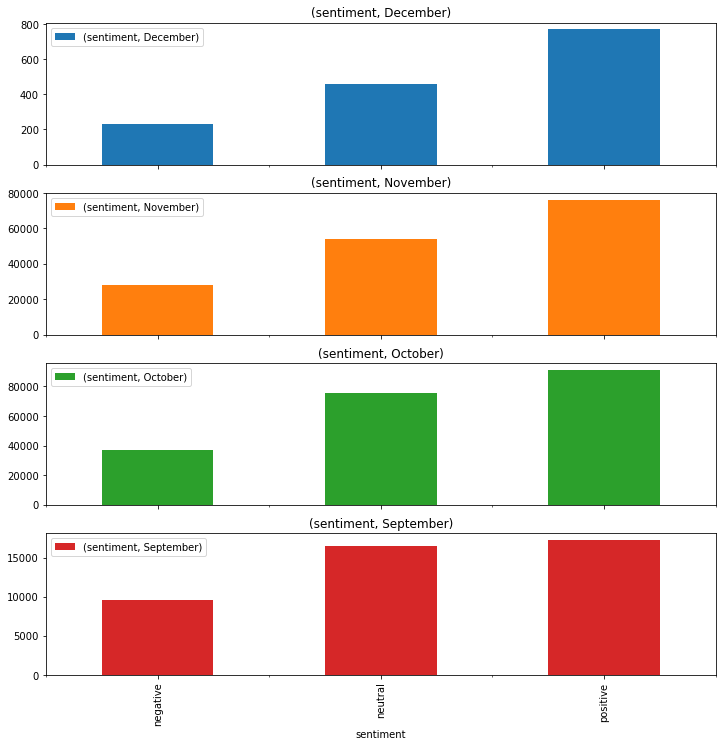

In [60]:
monthly_sentiment.unstack(level=0).plot(kind='bar', subplots=True, figsize=(12,12));

In [78]:
multi = apple_df.set_index(['date', 'sentiment'])

In [121]:
multi.groupby(multi.date.dt.strftime('%B'))['sentiment'].value_counts()
monthly_sentiment = pd.DataFrame(monthly_sentiment)

AttributeError: 'DataFrame' object has no attribute 'date'

In [122]:
multi

name        username  retweets_count  \
date       sentiment                                                           
2020-11-28 positive           HyperNavJack27    jack_mangano               0   
           positive             Erik Engheim     erikengheim               0   
           positive           Armando Monroy           ratzo               0   
           neutral          Matthew S. Smith    matt_on_tech               1   
           negative   Danel Omen ➐ he/him.®️        heck_wtf               0   
...                                      ...             ...             ...   
2020-09-01 negative                 Chihibot        chihibot               0   
           negative                    Yuyo™   alacraneros47               0   
           neutral      Grégory Thiell 🧢🌿🚗⚡️         gthiell               0   
           neutral               ずみ@zoomishi        zoomishi               0   
           neutral         YT Vince Montiero  vince_montiero               0   

                        search_term  likes_count language  \
date       sentiment                                        
2020-11-28 positive   apple silicon           10       en   
           positive   apple silicon            1       en   
           positive   apple silicon            2       en   
           neutral    apple silicon            4       en   
           negative   apple silicon            0       en   
...                             ...          ...      ...   
2020-09-01 negative       iphone 12            0       en   
           negative       iphone 12            0       en   
           neutral        iphone 12            0       en   
           neutral        iphone 12            0       en   
           neutral        iphone 12            0       en   

                                                                c_tweet  
date       sentiment                                                     
2020-11-28 positive   borderlands in on apple silicon yes yes it pla...  
           positive   mac mini vs mac pro interesting review of pros...  
           positive   and can only imagine what the apple silicon fo...  
           neutral    to repeat something said at the debut if apple...  
           negative   is not the problem pixel size is the problem a...  
...                                                                 ...  
2020-09-01 negative   new restoration project coming on sunday ll fi...  
           negative   drop the new iphone already phone less face wi...  
           neutral    ll upgrade my iphone pro max to iphone if they...  
           neutral    rumor airtags could launch alongside iphone in...  
           neutral    if your money is unlimited what would you buy ...  

[407125 rows x 7 columns]

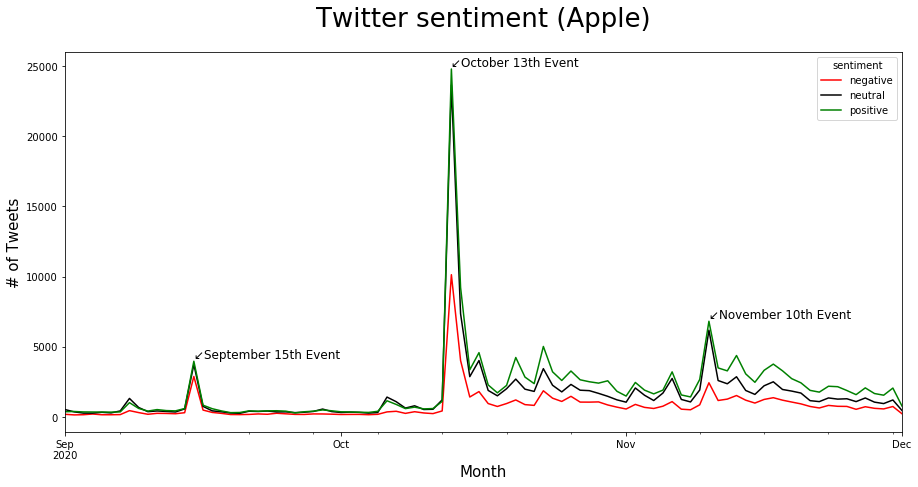

In [231]:
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
multi.groupby(['date','sentiment']).count()['c_tweet'].unstack().plot(ax=ax,color=('red','black', 'green'));

ax.annotate("↙September 15th Event", xy=(pd.Timestamp('2020-9-15'), 4200), fontsize=12)
ax.annotate("↙October 13th Event", xy=(pd.Timestamp('2020-10-13'), 25000), fontsize=12)
ax.annotate("↙November 10th Event", xy=(pd.Timestamp('2020-11-10'), 7000), fontsize=12)
#fig.subplots_adjust(top=0.75)
plt.xlabel('Month', size=15) 
plt.ylabel('# of Tweets', size=15)
ax.set_title('Twitter sentiment (Apple)', fontsize=26, pad='25.0');

In [ ]:
# Apple Event Sep 15.
# Streamed live on Sep 15, 2020
#latest updates for Apple Watch, iPad Air, and more.

# --------------------

# Apple event: latest updates for HomePod mini, iPhone, and more. 
#  Oct 13, 2020
# https://www.youtube.com/watch?v=KR0g-1hnQPA

#-----------------

# Apple 'one more thing' event. M1 Chip etc. 
# Streamed live on Nov 10, 2020
# https://www.youtube.com/watch?v=5AwdkGKmZ0I


# Google monthly sentiment

In [ ]:
multi = apple_df.set_index(['date', 'sentiment'])

In [110]:
google_multi = google_df.set_index(['date', 'sentiment'])

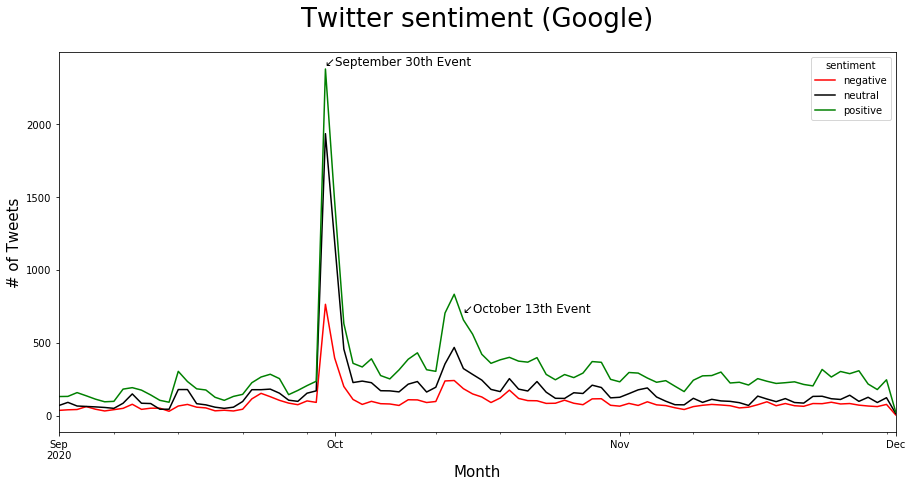

In [229]:
fig, ax = plt.subplots(figsize=(15,7))
google_multi.groupby(['date','sentiment']).count()['c_tweet'].unstack().plot(ax=ax,color=('red','black', 'green'));
ax.annotate("↙September 30th Event", xy=(pd.Timestamp('2020-9-30'), 2400), fontsize=12)
ax.annotate("↙October 13th Event", xy=(pd.Timestamp('2020-10-15'), 710), fontsize=12)
plt.xlabel('Month', size=15) 
plt.ylabel('# of Tweets', size=15)
ax.set_title('Twitter sentiment (Google)', fontsize=26, pad='25.0');


In [230]:
# October 13th - Google Has hardware event
# https://www.androidcentral.com/everything-you-can-expect-google-october-15-hardware-event


# September 30th Pixel 5 Event
#https://techcrunch.com/2020/09/30/watch-googles-pixel-5-event-live-right-here/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAHmVz7Vlrdb6BLQ5H0ewKvlDfrWdnL6N_1VIcbQc3iRyxohZUekwceMcQ5Y7w6tKyLCSNXFkpxMTmce2eOIxfwBYy4qxa2VwzifgU3Ewrmr3Y3E3JOhhWMJGYga5Y140jWYYb4zFqIMRX9WAilifirdDl3QAqZfbsvzAvkZwLEIH
